# Portfolio Optimization 

## Config & Imports
Set up configuration parameters amd imports neccessary libaries. 
The configuration defines stocks that will be analyzed, the time period, and key parameters like the risk-free rate. 

In [18]:
# Import required libraries 
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from fredapi import Fred

# Configuration
CONFIG = {
    'TICKERS': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'BRK-B'],
    'START_DATE': datetime.now() - timedelta(days=5*365),  # 5 years ago
    'END_DATE': datetime.now(),  # Today
    'INTERVAL': '1mo',  # Monthly data
    'RF_ANNUAL': None,  # Will fetch from FRED
    'ALLOW_SHORTS': False,  # Long-only portfolios
    'FREQUENCY': 'monthly',
    'FRED_API_KEY': '80d939285a25091784ba2f5be77fa106'
}

def annualization_factor(freq): 
   # Convert frequency to annulization factor 
   if freq == 'daily':
      return 252
   elif freq == 'weekly':
      return 52
   elif freq == 'monthly':
      return 12
   else: 
      raise ValueError(f"Unsupported frequency: {freq}")

# Set risk-free rate 
def get_rf_rate():
   # Fetch curent risk-free rate from FRED
   fred = Fred(api_key = '80d939285a25091784ba2f5be77fa106')
   ten_year_treasury_rate = fred.get_series('GS10') / 100
   # Get 10-year Treasury Constant Maturity Rate (most recent)
   rf_rate = ten_year_treasury_rate[-1] # Convert to decimal 
   return rf_rate

# Fetch risk-free rate
CONFIG['RF_ANNUAL'] = get_rf_rate()

# Checkpoint: Print configuration 
print("Current Configuration:")
for key, value in CONFIG.items():
   if key!= 'FRED_API_KEY': # Don't print API key
      print(f"  {key}: {value}")
print(f"\nAnnualization factor: {annualization_factor(CONFIG['FREQUENCY'])}")
print(f"Date range: {CONFIG['START_DATE'].strftime('%Y-%m-%d')} to {CONFIG['END_DATE'].strftime('%Y-%m-%d')}")
print(f"Risk-free rate: {CONFIG['RF_ANNUAL']:.4f} ({CONFIG['RF_ANNUAL']*100:.2f}%)")
      


Current Configuration:
  TICKERS: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'BRK-B']
  START_DATE: 2020-10-23 13:45:14.848788
  END_DATE: 2025-10-22 13:45:14.848812
  INTERVAL: 1mo
  RF_ANNUAL: 0.0412
  ALLOW_SHORTS: False
  FREQUENCY: monthly

Annualization factor: 12
Date range: 2020-10-23 to 2025-10-22
Risk-free rate: 0.0412 (4.12%)


/var/folders/q3/lqkxfhqd69scqh0r94mkbdm00000gn/T/ipykernel_61612/1437235916.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rf_rate = ten_year_treasury_rate[-1] # Convert to decimal


## Data Import (yfinance)
Fetch actual stock price data from yfinance. 
Will need to adjust closing prices for all tickers over the 5-year period, then clean data by forward-filling any missing values and dropping any remaining NaNs. 

In [19]:
# Data import 
def fetch_prices(tickers, start_date, end_date, interval):
    # Fetch adjusted closing prices for given tickers
    # Returns: DataFrame with forward-filled, cleaned price data
    print(f"Fetching data for {len(tickers)} tickers...")
    prices = yf.download(tickers, start=start_date, end=end_date, 
                        interval=interval, progress=False)
    
    # Handle multi-level columns - get Close prices 
    if prices.columns.nlevels > 1:
        prices = prices['Close']  # Using Close since Adj Close not available for monthly
    else:
        # Single level columns - prices should already be Close
        pass
    
    # Forward-fill missing values, then drop any remaining NaNs (updated syntax)
    prices = prices.ffill().dropna()
    
    return prices

# Fetch the price data
prices = fetch_prices(CONFIG['TICKERS'], CONFIG['START_DATE'], 
                     CONFIG['END_DATE'], CONFIG['INTERVAL'])

# Checkpoint: verify data quality 
print(f"\nData shape: {prices.shape}")
print(f"Date range: {prices.index[0].strftime('%Y-%m-%d')} to {prices.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of observations: {len(prices)}")
print(f"Number of assets: {prices.shape[1]}")
print("\nFirst few rows:")
print(prices.head())
assert prices.isnull().sum().sum() == 0, "Should have no missing values after cleaning"

/var/folders/q3/lqkxfhqd69scqh0r94mkbdm00000gn/T/ipykernel_61612/3371259864.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(tickers, start=start_date, end=end_date,


Fetching data for 8 tickers...

Data shape: (60, 8)
Date range: 2020-11-01 to 2025-10-01
Number of observations: 60
Number of assets: 8

First few rows:
Ticker            AAPL        AMZN       BRK-B       GOOGL        META  \
Date                                                                     
2020-11-01  115.802055  158.401993  228.910004   87.119141  275.273010   
2020-12-01  129.292587  162.846497  231.869995   87.031738  271.486389   
2021-01-01  128.581284  160.309998  227.869995   90.742142  256.747223   
2021-02-01  118.155251  154.646500  240.509995  100.403008  256.041534   
2021-03-01  119.200340  154.703995  255.470001  102.419609  292.725464   

Ticker            MSFT       NVDA        TSLA  
Date                                           
2020-11-01  205.255798  13.360716  189.199997  
2020-12-01  213.820282  13.015271  235.223328  
2021-01-01  222.991409  12.954044  264.510010  
2021-02-01  223.395203  13.676802  225.166672  
2021-03-01  227.176132  13.311559  222.6

## Returns and Annulization
Convert price data in returns. Then, calculate simple returns (percentage changes), then annualize both expected returns and covariance matrix by multiplying by annualization factor

In [20]:
# Returns & Annualization
def calculate_returns(prices):
    """Calculate simple returns from price data"""
    return prices.pct_change().dropna()

# Calculate returns
R = calculate_returns(prices)
print(f"Returns shape: {R.shape}")  
print(f"Date range: {R.index[0].strftime('%Y-%m-%d')} to {R.index[-1].strftime('%Y-%m-%d')}")

# Annualization factor
ann_factor = annualization_factor(CONFIG['FREQUENCY'])
print(f"Annualization factor: {ann_factor}")

# Calculate annualized expected returns and covariance matrix 
mu = R.mean() * ann_factor  # Annualized expected returns 
Sigma = R.cov() * ann_factor  # Annualized covariance matrix 

print(f"\nExpected returns shape: {mu.shape}")
print(f"Covariance matrix shape: {Sigma.shape}")  

# Checkpoint: Display key statistics
print("\nAnnualized Expected Returns (%):")
print((mu * 100).round(2))
print("\nAnnualized Volatilities (%):")
print((np.sqrt(np.diag(Sigma)) * 100).round(2))  

# Verify covariance matrix is positive semi-definite
eigenvals = np.linalg.eigvals(Sigma)  
min_eigenval = np.min(eigenvals)
print(f"\nMinimum eigenvalue: {min_eigenval:.2e}")
if min_eigenval < -1e-8:
    print("WARNING: Covariance matrix not positive semi-definite!")
    # Add small ridge to make it PSD
    Sigma = Sigma + 1e-8 * np.eye(Sigma.shape[0])  
    print("Added ridge regularization (1e-8)")
else:
    print("Covariance matrix is positive semi-definite ✓")

Returns shape: (59, 8)
Date range: 2020-12-01 to 2025-10-01
Annualization factor: 12

Expected returns shape: (8,)
Covariance matrix shape: (8, 8)

Annualized Expected Returns (%):
Ticker
AAPL     19.25
AMZN     11.04
BRK-B    17.27
GOOGL    25.30
META     28.44
MSFT     21.38
NVDA     66.16
TSLA     34.60
dtype: float64

Annualized Volatilities (%):
[24.98 30.81 18.75 27.05 40.95 22.25 50.86 61.11]

Minimum eigenvalue: 1.75e-02
Covariance matrix is positive semi-definite ✓


## Markowitz Efficient Frontier

### Function defintion

In [21]:
# Markowitz Efficient Frontier 
def markowitz_optimize(mu, Sigma, target_return, allow_shorts=False):
    """
    Minimize portfolio variance for a given target return
    This is the core of Markowitz mean-variance optimization
    Returns: (weights, portfolio_return, portfolio_vol, sharpe_ratio)
    """
    n = len(mu) # Number of assets

    # Objective function: portfolio variance (what we want to minimize)
    def objective(w):
        return w.T @ Sigma @ w # w^T @ Sigma * w (matrix multiplication for variance) 
    
    # Constraints: weights must sum to 1 AND achiece target return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
        {'type': 'eq', 'fun': lambda w: w.T @ mu - target_return}  # target return achieved
    ]

    # Bounds: can short sell or no? 
    if allow_shorts:
        bounds = [(-1, 1) for _ in range(n)] # Allow short positions up to 100% 
    else:
        bounds = [(0, 1) for _ in range(n)] # Long-only (no shorting)

    # Initial guess: start with equal weights
    x0 = np.ones(n) / n

    # Optimize using Sequential Least Squares Programming 
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if optimization succeeded
    if not result.success:
        return None, None, None, None
    
    # Extract results
    weights = result.x
    portfolio_return = weights.T @ mu # Expected return 
    portfolio_vol = np.sqrt(weights.T @ Sigma @ weights) # Standard deviation
    sharpe_ratio = (portfolio_return - CONFIG['RF_ANNUAL']) / portfolio_vol # Risk-adjusted return

    return weights, portfolio_return, portfolio_vol, sharpe_ratio

    

### Frontier Generation

In [22]:
# Generaste efficient frontier
print(f"Target return range: {mu.min():.4f} to {mu.max():.4f}")

# Creata target returns from min to max with 50 points
# Gives smooth cruve on the frontier
target_returns = np.linspace(mu.min(), mu.max(), 50)

# Store frontier results 
frontier_results =[] 

# For each target return, find minimum variance portfolio
for target_ret in target_returns:
    weights, port_ret, port_vol, sharpe = markowitz_optimize(
        mu, Sigma, target_ret, CONFIG['ALLOW_SHORTS']
    )

    # Only keep succesful optimizations 
    if weights is not None: 
        frontier_results.append({
            'target_return': target_ret,
            'portfolio_return': port_ret,
            'portfolio_vol': port_vol,
            'sharpe_ratio': sharpe,
            'weights': weights.copy() # Store weights for later analysis
        })

print(f"Generated {len(frontier_results)} frontier points")

# Convert to Dataframe for easier analysis
frontier_df = pd.DataFrame(frontier_results)
print(f"Return range: {frontier_df['portfolio_return'].min():.4f} to {frontier_df['portfolio_return'].max():.4f}")
print(f"Volatility range: {frontier_df['portfolio_vol'].min():.4f} to {frontier_df['portfolio_vol'].max():.4f}")
print(f"Sharpe range: {frontier_df['sharpe_ratio'].min():.4f} to {frontier_df['sharpe_ratio'].max():.4f}")

Target return range: 0.1104 to 0.6616
Generated 50 frontier points
Return range: 0.1104 to 0.6616
Volatility range: 0.1557 to 0.5086
Sharpe range: 0.2246 to 1.2811


## Sharpe Ratio Maximization (Tangency Portfolio)

### Function definition

In [23]:
# Sharpe Ratio Maximiation 
def maximize_sharpe(mu, Sigma, rf_rate, allow_shorts=False):
    """
    Maximize Sharpe ratio to find tangency portfolio
    This finds the portfolio with the highest risk-adjusted returns
    Returns: (weights, portfolio_return, portfolio_vol, sharpe_ratio)
    """
    n = len(mu) # Num of assets

    # Objective function: negative Sharpe ratio (minimize to maximize)
    def objective(w):
        portfolio_return = w.T @ mu # expected retunr
        portfolio_vol = np.sqrt(w.T @ Sigma @ w) # Standard deviation
        sharpe = (portfolio_return - rf_rate) / portfolio_vol # Sharpe ratio 
        return -sharpe # Negative to minimize 
    
    # Constraaints: weights must sum to 1 
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # weights sum to 1
    ]

    # Bounds: sell or no? 
    if allow_shorts:
        bounds = [(-1, 1) for _ in range(n)]  # Allow short positions
    else:
        bounds = [(0, 1) for _ in range(n)]  # Long-
        
    # Initial guess: start with equal weights
    x0 = np.ones(n) / n

     # Optimize using Sequential Least Squares Programming
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)

    # Check if optimization succeeded
    if not result.success:
        return None, None, None, None
    
    # Extract results
    weights = result.x
    portfolio_return = weights.T @ mu # Expected return 
    portfolio_vol = np.sqrt(weights.T @ Sigma @ weights) # Standard deviation
    sharpe_ratio = (portfolio_return - rf_rate / portfolio_vol) # Risk-adjusted return 

    return weights, portfolio_return, portfolio_vol, sharpe_ratio
    

### Tangency Portfolio 

In [24]:
# Find tangency portfolio (Max Sharpe)
tangency_weights, tangency_return, tangency_vol, tangency_sharpe = maximize_sharpe(
    mu, Sigma, CONFIG['RF_ANNUAL'], CONFIG['ALLOW_SHORTS']
)

if tangency_weights is not None: 
    print(f"\nTangency Portfolio Results:")
    print(f"Return: {tangency_return:.4f} ({tangency_return*100:.2f}%)")
    print(f"Volatility: {tangency_vol:.4f} ({tangency_vol*100:.2f}%)")
    print(f"Sharpe Ratio: {tangency_sharpe:.4f}")
    print(f"\nWeights sum: {np.sum(tangency_weights):.6f}")
else:
    print("Failed to find tangency portfolio")


Tangency Portfolio Results:
Return: 0.3898 (38.98%)
Volatility: 0.2721 (27.21%)
Sharpe Ratio: 0.2384

Weights sum: 1.000000


## Results (Frontier + Points + Weights)

### Calcualte reference portfolios 

In [25]:
def equal_weight_portfolio(mu, Sigma):
    """Calculate equal-weight portfolio statistics"""
    n = len(mu)
    weights = np.ones(n) / n # Equal weights: 1/n for each asset
    portfolio_return = weights.T @ mu 
    portfolio_vol = np.sqrt(weights.T @ Sigma @ weights)
    sharpe_ratio = (portfolio_return - CONFIG['RF_ANNUAL']) / portfolio_vol 
    return weights, portfolio_return, portfolio_vol, sharpe_ratio

# Calculate equal-weight portfolio
ew_weights, ew_return, ew_vol, ew_sharpe = equal_weight_portfolio(mu, Sigma)

# Checkpoint 
print(f"Equal-Weight Portfolio:")
print(f"  Return: {ew_return:.4f} ({ew_return*100:.2f}%)")
print(f"  Volatility: {ew_vol:.4f} ({ew_vol*100:.2f}%)")
print(f"  Sharpe: {ew_sharpe:.4f}")

Equal-Weight Portfolio:
  Return: 0.2793 (27.93%)
  Volatility: 0.2490 (24.90%)
  Sharpe: 0.9564


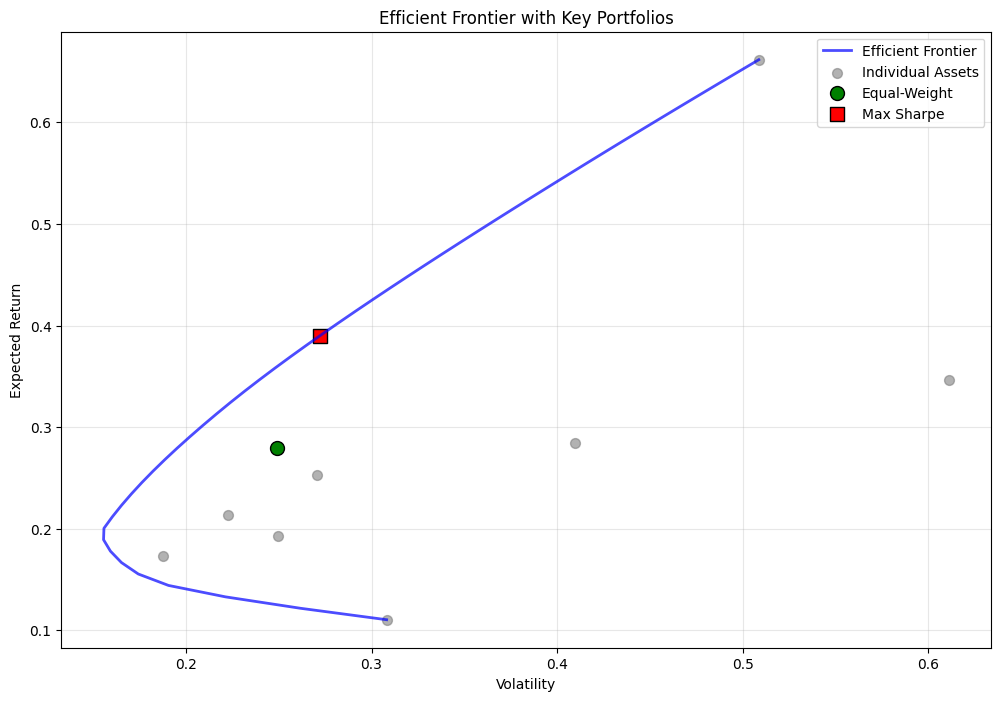

In [26]:
plt.figure(figsize=(12,8))

# Plot efficient frontier
if len(frontier_df) > 0:
    plt.plot(frontier_df['portfolio_vol'], frontier_df['portfolio_return'], 'b-', linewidth=2, label='Efficient Frontier', alpha=0.7)

# Plot individual assets
asset_vols = np.sqrt(np.diag(Sigma))
plt.scatter(asset_vols, mu, color='gray', s=50, alpha=0.6, label='Individual Assets')

# Plot key portfolios
plt.scatter(ew_vol, ew_return, color='green', s=100, marker='o', label='Equal-Weight',edgecolors='black', linewidth=1)
plt.scatter(tangency_vol, tangency_return, color='red', s=100, marker='s', label='Max Sharpe', edgecolors='Black', linewidth=1)

plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Key Portfolios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()